# Enviroment Setup

In [3]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from datetime import datetime
from collections import Counter

In [4]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import joblib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sample Data Loading

In [5]:
movie_df = pd.read_csv('../data/IMDb movies.csv') 
reduced_df = movie_df[['original_title', 'year', 'date_published','language',
       'genre', 'duration', 'country', 'director', 'writer',
       'production_company', 'actors', 'avg_vote', 'votes',
       'budget', 'worlwide_gross_income']]
clean_movie_df = reduced_df.dropna()
sample_df=clean_movie_df[clean_movie_df["budget"].str.startswith("$")]
sample_df=sample_df[clean_movie_df["worlwide_gross_income"].str.startswith("$")]
sample_df['budget'] = sample_df['budget'].str.replace('$','')
sample_df['worlwide_gross_income'] = sample_df['worlwide_gross_income'].str.replace('$','')
sample_df['budget'] = sample_df['budget'].astype(np.int64)
sample_df['worlwide_gross_income'] = sample_df['worlwide_gross_income'].astype(np.int64)
sample_df['year'] = sample_df['year'].astype(np.int64)
sample_df.head()

C:\Users\QiZheng\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-5-307ec6053615>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df=sample_df[clean_movie_df["worlwide_gross_income"].str.startswith("$")]


,original_title,year,date_published,language,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income
165,Das Cabinet des Dr. Caligari,1920,1920-02-27,German,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811
245,The Four Horsemen of the Apocalypse,1921,1923-04-16,None,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673
251,The Kid,1921,1923-11-26,"English, None","Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916
348,A Woman of Paris: A Drama of Fate,1923,1927-06-06,"None, English","Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233
415,The Gold Rush,1925,1925-10-23,"English, None","Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916


In [6]:
def extract_day(film_date):
    try:
        datetime_object = datetime.strptime(film_date, '%Y-%m-%d')
        film_day = datetime_object.timetuple().tm_yday
        return film_day
    except:
        return 0

In [7]:
sample_df['day']=sample_df['date_published'].apply(lambda x: extract_day(x))
sample_df=sample_df[sample_df['day']>0]
sample_df=sample_df.drop(['date_published'],axis=1)
sample_df.head()

,original_title,year,language,genre,duration,country,director,writer,production_company,actors,avg_vote,votes,budget,worlwide_gross_income,day
165,Das Cabinet des Dr. Caligari,1920,German,"Fantasy, Horror, Mystery",76,Germany,Robert Wiene,"Carl Mayer, Hans Janowitz",Decla-Bioscop AG,"Werner Krauss, Conrad Veidt, Friedrich Feher, ...",8.1,55601,18000,8811,58
245,The Four Horsemen of the Apocalypse,1921,None,"Drama, Romance, War",150,USA,Rex Ingram,"Vicente Blasco Ibáñez, June Mathis",Metro Pictures Corporation,"Pomeroy Cannon, Josef Swickard, Bridgetta Clar...",7.2,3058,800000,9183673,106
251,The Kid,1921,"English, None","Comedy, Drama, Family",68,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Carl Miller, Edna Purviance, Jackie Coogan, Ch...",8.3,109038,250000,26916,330
348,A Woman of Paris: A Drama of Fate,1923,"None, English","Drama, Romance",82,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Edna Purviance, Clarence Geldart, Carl Miller,...",7.0,4735,351000,11233,157
415,The Gold Rush,1925,"English, None","Adventure, Comedy, Drama",95,USA,Charles Chaplin,Charles Chaplin,Charles Chaplin Productions,"Charles Chaplin, Mack Swain, Tom Murray, Henry...",8.2,97480,923000,26916,296


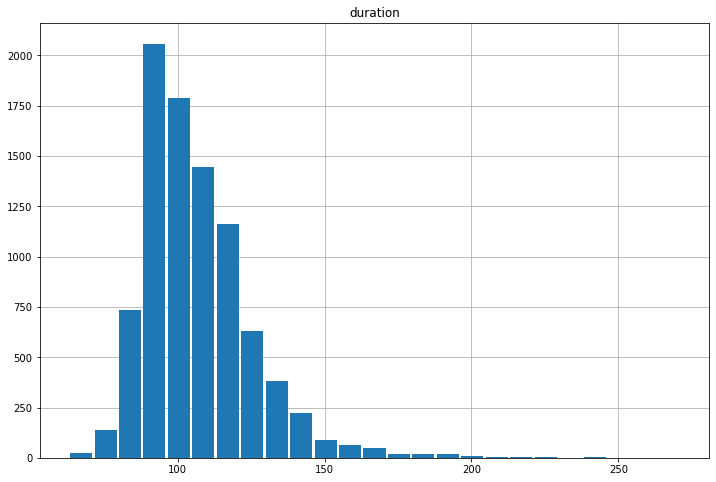

In [44]:
ax = sample_df.hist(column='duration', bins=25, grid=True, figsize=(12,8), zorder=2, rwidth=0.9)

In [8]:
list_of_languages = list(sample_df['language'].apply(lambda x:  [i for i in x.split(', ')]).values)
list_of_genres = list(sample_df['genre'].apply(lambda x:  [i for i in x.split(', ')]).values)
list_of_countries = list(sample_df['country'].apply(lambda x:  [i for i in x.split(', ')]).values)
list_of_actors = list(sample_df['actors'].apply(lambda x:  [i for i in x.split(', ')]).values)
list_of_directors = list(sample_df['director'].apply(lambda x:  [i for i in x.split(', ')]).values)
list_of_writers = list(sample_df['writer'].apply(lambda x:  [i for i in x.split(', ')]).values)
list_of_companies = list(sample_df['production_company'].apply(lambda x:  [i for i in x.split(', ')]).values)

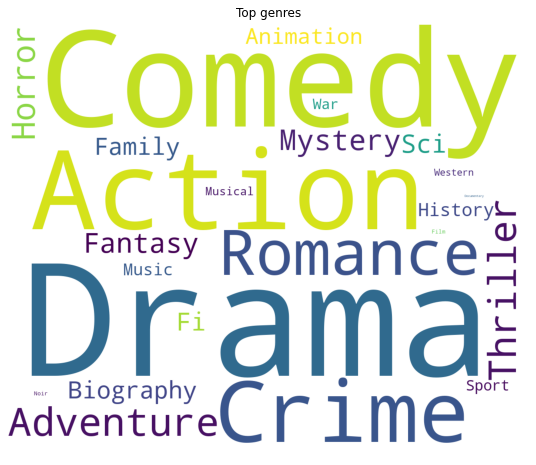

In [9]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()

In [25]:
rev_feature_df = pd.read_csv("../model/encoded_data/feature_importance_rev_xgb.csv")
rat_feature_df = pd.read_csv("../model/encoded_data/feature_importance_rate_xgb.csv")
rev_feature_df.head()

,feature,importance
0,year,0.002332
1,duration,0.001710
2,votes,0.025174
3,budget,0.080473
4,day,0.002321


In [40]:
rev_topfeature_df=rev_feature_df.sort_values(by=['importance'], ascending=False).head(10)
rev_topfeature_df

,feature,importance
3,budget,0.080473
30,genre_Adventure,0.027131
2,votes,0.025174
22,language_Afrikaans,0.024645
38,genre_Animation,0.022773
245,company_Lucasfilm,0.018542
364,actor_Josh Gad,0.017618
312,actor_James McAvoy,0.016852
83,director_Bill Condon,0.016790
355,actor_Chris Pratt,0.016640


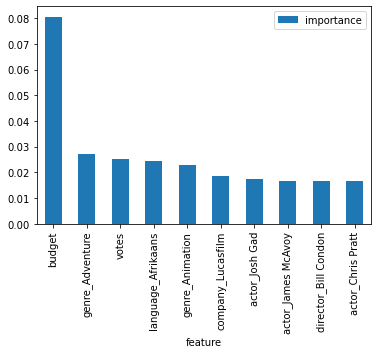

In [41]:
ax = rev_topfeature_df.plot.bar(x='feature', y='importance', rot=90)

In [37]:
rat_topfeature_df=rat_feature_df.sort_values(by=['importance'], ascending=False).head(10)
rat_topfeature_df

,feature,importance
28,genre_Drama,0.079796
40,genre_Biography,0.020958
327,actor_Sam Neill,0.017833
122,director_Aaron Seltzer,0.016295
2,votes,0.015619
266,company_Boll Kino Beteiligungs GmbH & Co. KG,0.013655
49,country_USA,0.013213
64,country_Turkey,0.012922
35,genre_Horror,0.012060
433,actor_Alicia Silverstone,0.010304


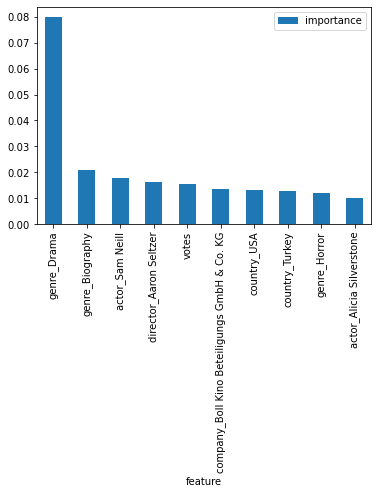

In [39]:
ax = rat_topfeature_df.plot.bar(x='feature', y='importance', rot=90)

In [26]:
rev_genre_df=rev_feature_df[rev_feature_df["feature"].str.startswith("genre_")]
rev_genre_df['feature'] = rev_genre_df['feature'].str.replace('genre_','')
rat_genre_df=rat_feature_df[rat_feature_df["feature"].str.startswith("genre_")]
rat_genre_df['feature'] = rat_genre_df['feature'].str.replace('genre_','')

<ipython-input-26-0e4f77a6d63c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev_genre_df['feature'] = rev_genre_df['feature'].str.replace('genre_','')
<ipython-input-26-0e4f77a6d63c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rat_genre_df['feature'] = rat_genre_df['feature'].str.replace('genre_','')


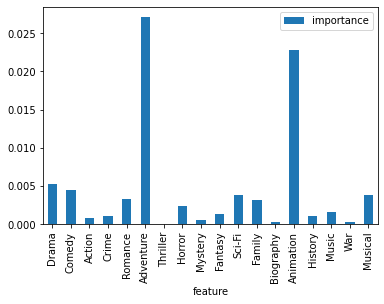

In [27]:
ax = rev_genre_df.plot.bar(x='feature', y='importance', rot=90)

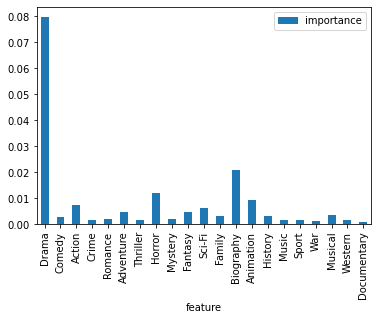

In [28]:
ax = rat_genre_df.plot.bar(x='feature', y='importance', rot=90)

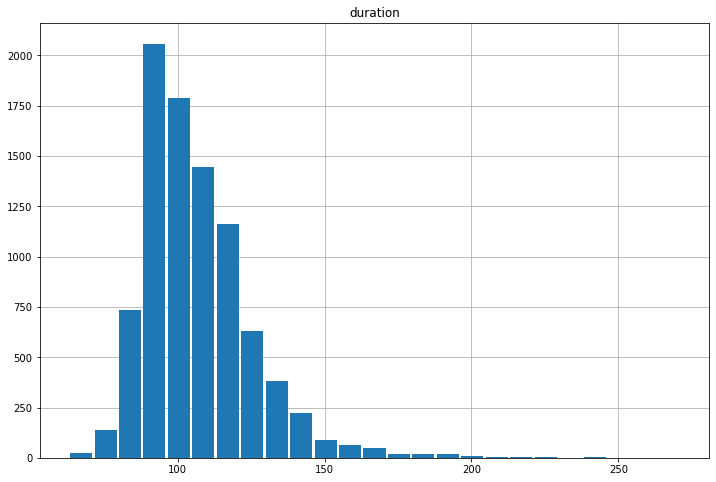

In [3]:
rev_select_sample_df = pd.read_csv("model/encoded_data/select_sample_data_rev_xgb.csv")
revenue_y = pd.read_csv("model/encoded_data/revenue_xgb.csv")
rat_select_sample_df = pd.read_csv("model/encoded_data/select_sample_data_rate_xgb.csv")
rate_y = pd.read_csv("model/encoded_data/rating_xgb.csv")

In [4]:
rev_select_sample_df.head()

,year,duration,votes,budget,day,language_Spanish,language_French,language_Russian,language_German,language_Italian,...,actor_Daniel Stern,actor_Blythe Danner,actor_Catherine O'Hara,actor_Allison Janney,actor_Karl Urban,actor_Vanessa Hudgens,actor_Christoph Waltz,actor_Tyler Perry,actor_Octavia Spencer,actor_Dave Bautista
0,1920,76,55601,18000,58,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1921,150,3058,800000,106,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1921,68,109038,250000,330,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1923,82,4735,351000,157,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1925,95,97480,923000,296,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
rev_select_sample_df["budget"].mean()

25100977.97102593

In [6]:
X_rev = rev_select_sample_df
X_rat = rat_select_sample_df

# Data Scaler

In [7]:
duration_scaler=MinMaxScaler().fit(X_rev[["duration"]])
day_scaler=MinMaxScaler().fit(X_rev[["day"]])

# Revenue Predictor Load

In [8]:
revenue_filename = 'model/revenue_xgboost_model.sav'
revenue_regressor = joblib.load(revenue_filename)

In [9]:
revenue_inputs={
    # Compulsory inputs
    "comp":{},
    # Optional inputs
    "opt":{}}
revenue_inputs["comp"]["year"]=2021
revenue_inputs["comp"]["day"]=355
revenue_inputs["comp"]["duration"]=120
revenue_inputs["comp"]["votes"]=500000
revenue_inputs["comp"]["budget"]=25000000
revenue_inputs["opt"]["language_"]=[] # Spanish/French/Russian etc.
revenue_inputs["opt"]["genre_"]=[] # Drama/Action/Comedy etc.
revenue_inputs["opt"]["country_"]=[] # UK/China/France/Australia etc. 
revenue_inputs["opt"]["director_"]=[] # Woody Allen/Renny Harlin/Paul Schrader etc.
revenue_inputs["opt"]["writer_"]=[] # Zak Penn/Tyler Perry/Christopher Nolan etc.
revenue_inputs["opt"]["company_"]=[] # Warner Bros./Columbia Pictures/Paramount Pictures etc.
revenue_inputs["opt"]["actor_"]=[] # Tom Hanks/Bruce Willis/Tom Cruise etc.

In [10]:
rev_features=rev_select_sample_df.columns.tolist()

In [11]:
emp_dict = {}
for feature in rev_features:
    emp_dict[feature] = [0]
test_df =pd.DataFrame.from_dict(emp_dict)
test_df

,year,duration,votes,budget,day,language_Spanish,language_French,language_Russian,language_German,language_Italian,...,actor_Daniel Stern,actor_Blythe Danner,actor_Catherine O'Hara,actor_Allison Janney,actor_Karl Urban,actor_Vanessa Hudgens,actor_Christoph Waltz,actor_Tyler Perry,actor_Octavia Spencer,actor_Dave Bautista
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Language Input
revenue_inputs["opt"]["language_"].append("Spanish") # English/Spanish/French/Russian etc.
# Genre Input
revenue_inputs["opt"]["genre_"].append("Drama") # Drama/Action/Comedy etc.
# Country Input
revenue_inputs["opt"]["country_"].append("UK") # UK/China/France/Australia etc. 
# Director Input
revenue_inputs["opt"]["director_"].append("Woody Allen") # Woody Allen/Renny Harlin/Paul Schrader etc.
# Writer Input
revenue_inputs["opt"]["writer_"].append("Zak Penn") # Zak Penn/Tyler Perry/Christopher Nolan etc.
# Company Input
revenue_inputs["opt"]["company_"].append("Warner Bros.") # Warner Bros./Columbia Pictures/Paramount Pictures etc.
# Actor Input
revenue_inputs["opt"]["actor_"].append("Tom Hanks") # Tom Hanks/Bruce Willis/Tom Cruise etc.

In [13]:
for rev_comp_key in revenue_inputs["comp"].keys():
    test_df[rev_comp_key]=revenue_inputs["comp"][rev_comp_key]
for rev_opt_key in revenue_inputs["opt"].keys():
    for x in revenue_inputs["opt"][rev_opt_key]:
        feature = rev_opt_key + x
        if feature in rev_features:
            test_df[feature]=1

In [14]:
test_df["duration"]=duration_scaler.transform(test_df[["duration"]])
test_df["day"]=day_scaler.transform(test_df[["day"]])

In [15]:
test_df

,year,duration,votes,budget,day,language_Spanish,language_French,language_Russian,language_German,language_Italian,...,actor_Daniel Stern,actor_Blythe Danner,actor_Catherine O'Hara,actor_Allison Janney,actor_Karl Urban,actor_Vanessa Hudgens,actor_Christoph Waltz,actor_Tyler Perry,actor_Octavia Spencer,actor_Dave Bautista
0,2021,0.274038,500000,25000000,0.969863,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
revenue_pred = revenue_regressor.predict(test_df)
print("$ %d"%(revenue_pred))

$ 295511776


# Rating Predictor Load

In [17]:
rate_filename = 'model/rating_xgboost_model.sav'
rate_regressor = joblib.load(rate_filename)

In [18]:
rate_inputs={
    # Compulsory inputs
    "comp":{},
    # Optional inputs
    "opt":{}}
rate_inputs["comp"]["year"]=2021
rate_inputs["comp"]["day"]=355
rate_inputs["comp"]["duration"]=120
rate_inputs["comp"]["votes"]=500000
rate_inputs["comp"]["budget"]=25000000
rate_inputs["opt"]["language_"]=[] # English/Spanish/French/Russian etc.
rate_inputs["opt"]["genre_"]=[] # Drama/Action/Comedy etc.
rate_inputs["opt"]["country_"]=[] # USA/UK/China/France/Australia etc. 
rate_inputs["opt"]["director_"]=[] # Woody Allen/Renny Harlin/Paul Schrader etc.
rate_inputs["opt"]["writer_"]=[] # Zak Penn/Tyler Perry/Christopher Nolan etc.
rate_inputs["opt"]["company_"]=[] # Warner Bros./Columbia Pictures/Paramount Pictures etc.
rate_inputs["opt"]["actor_"]=[] # Nicolas Cage/Bruce Willis/Tom Cruise etc.

In [19]:
rate_features=rat_select_sample_df.columns.tolist()

In [20]:
emp_dict = {}
for feature in rate_features:
    emp_dict[feature] = [0]
rate_test_df =pd.DataFrame.from_dict(emp_dict)
rate_test_df

,year,duration,votes,budget,day,language_English,language_Spanish,language_French,language_Russian,language_German,...,actor_Queen Latifah,actor_Demián Bichir,actor_Natascha McElhone,actor_Johnathon Schaech,actor_Emily Watson,actor_Michael Angarano,actor_Kate Mara,actor_Diane Kruger,actor_Vanessa Hudgens,actor_Michael Ealy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Language Input
rate_inputs["opt"]["language_"].append("English") # English/Spanish/French/Russian etc.
# Genre Input
rate_inputs["opt"]["genre_"].append("Drama") # Drama/Action/Comedy etc.
# Country Input
rate_inputs["opt"]["country_"].append("USA") # UK/China/France/Australia etc. 
# Director Input
rate_inputs["opt"]["director_"].append("Woody Allen") # Woody Allen/Renny Harlin/Paul Schrader etc.
# Writer Input
rate_inputs["opt"]["writer_"].append("Zak Penn") # Zak Penn/Tyler Perry/Christopher Nolan etc.
# Company Input
rate_inputs["opt"]["company_"].append("Warner Bros.") # Warner Bros./Columbia Pictures/Paramount Pictures etc.
# Actor Input
rate_inputs["opt"]["actor_"].append("Nicolas Cage") # Nicolas Cage/Bruce Willis/Tom Cruise etc.

In [22]:
for rate_comp_key in rate_inputs["comp"].keys():
    rate_test_df[rate_comp_key]=rate_inputs["comp"][rate_comp_key]
for rate_opt_key in rate_inputs["opt"].keys():
    for x in rate_inputs["opt"][rate_opt_key]:
        feature = rate_opt_key + x
        if feature in rate_features:
            rate_test_df[feature]=1

In [23]:
rate_test_df["duration"]=duration_scaler.transform(rate_test_df[["duration"]])
rate_test_df["day"]=day_scaler.transform(rate_test_df[["day"]])

In [24]:
rate_test_df

,year,duration,votes,budget,day,language_English,language_Spanish,language_French,language_Russian,language_German,...,actor_Queen Latifah,actor_Demián Bichir,actor_Natascha McElhone,actor_Johnathon Schaech,actor_Emily Watson,actor_Michael Angarano,actor_Kate Mara,actor_Diane Kruger,actor_Vanessa Hudgens,actor_Michael Ealy
0,2021,0.274038,500000,25000000,0.969863,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
rate_pred = rate_regressor.predict(rate_test_df)
print("%.2f" %rate_pred)

8.10
